# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
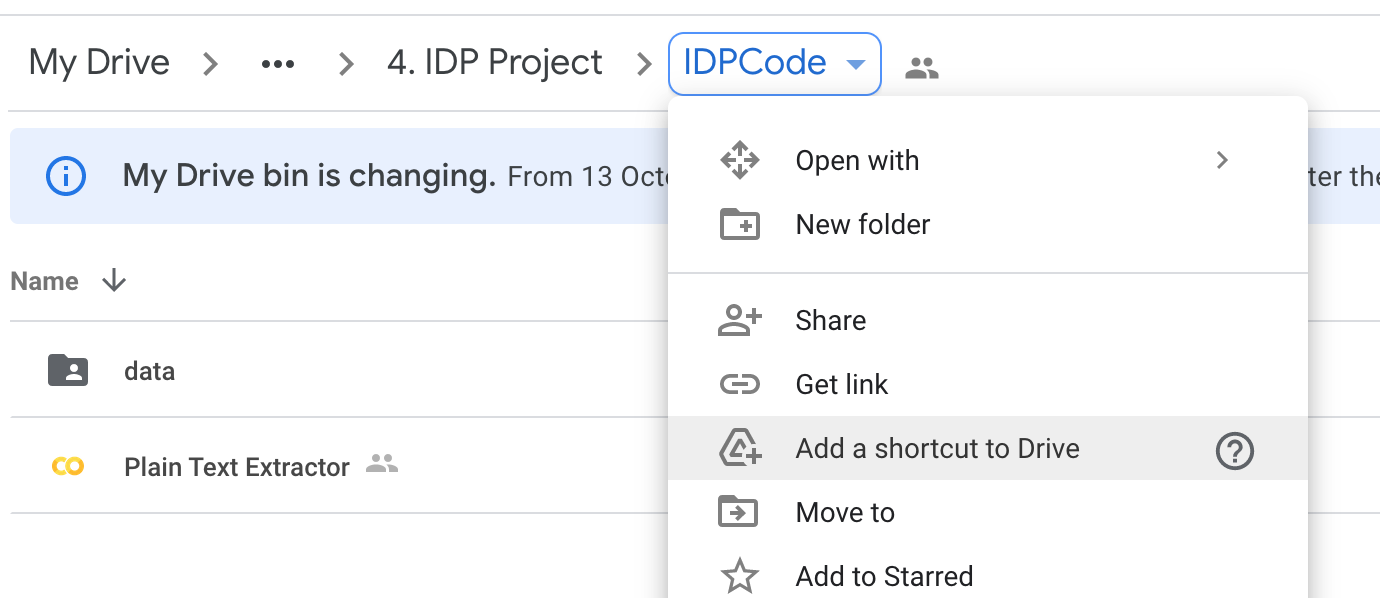
2. Run the command below to connect the GDrive:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

In [ ]:
# Library install examples: https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb
!pip install pdfplumber
!pip install PyPDF2
!pip install tika
!pip install xlsxwriter
!pip install pikepdf
!pip install pdfminer.six
!pip install folderstats

# Start from here if you run in local !!

In [1]:
from os import path
from glob import glob
import pandas as pd
import os
import re
import time
import sys
import string

# show execution time of cells
%load_ext autotime

# Show all of columns in dataframe: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIRECTORY='/Users/farukcankaya/Google Drive/AllPapers'

time: 554 µs


In [2]:
# Utility functions
import folderstats
def find_data_files(directory):
    df = folderstats.folderstats(DATA_DIRECTORY, ignore_hidden=True)
    df_files = df[df['folder']==False]
    df_pdf_files = df_files[df_files['extension']=='pdf']
    df_pdf_files_in_depth_1 = df_pdf_files[df_pdf_files['depth']==1]
    
    return df_pdf_files_in_depth_1['path']

millis = lambda: int(round(time.time() * 1000))

def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
    
def reorder_columns(dataframe):
    cols = list(dataframe.columns.values)
    page_cols = [k for k in cols if k.startswith('page_')]
    cols.remove('file_path')
    cols.remove('total_page_count')

    meta_cols = list(set(cols)-set(page_cols))

    dataframe[['file_path', 'total_page_count'] + cols + meta_cols].head()
    return dataframe

time: 5.55 ms


In [3]:
papers = find_data_files(DATA_DIRECTORY)

time: 2.52 s


# Plain Text Extraction from PDF
There are 4 available good pyton package candidates to extract plain text from PDF files.
- Tika: https://tika.apache.org/
- PyPDF2: https://pypi.org/project/PyPDF2/ beside converting PDF to plain text, it is able to extract meta data.
- Pdfplumber: https://github.com/jsvine/pdfplumber
- PDFminer3: https://pypi.org/project/pdfminer3/

## Tika
##### Example usage:
```python
data = parser.from_file(file_path)
```

##### Methods:
*   `data.keys()` : ['content', 'metadata', 'status']
*   `data.items()` : ['content':"...", 'metadata':{'author':"...", ...} 'status': 200]
*   `data['content']` : "..."
*   `data['metadata']` : ['Author', 'Content-Type', 'Creation-Date', 'Keywords', 'Last-Modified', 'Last-Save-Date', 'X-Parsed-By', 'X-TIKA:content_handler', 'X-TIKA:embedded_depth', 'X-TIKA:parse_time_millis', 'access_permission:assemble_document', 'access_permission:can_modify', 'access_permission:can_print', 'access_permission:can_print_degraded', 'access_permission:extract_content', 'access_permission:extract_for_accessibility', 'access_permission:fill_in_form', 'access_permission:modify_annotations', 'cp:subject', 'created', 'creator', 'date', 'dc:creator', 'dc:description', 'dc:format', 'dc:subject', 'dc:title', 'dcterms:created', 'dcterms:modified', 'description', 'meta:author', 'meta:creation-date', 'meta:keyword', 'meta:save-date', 'modified', 'pdf:PDFVersion', 'pdf:charsPerPage', 'pdf:docinfo:created', 'pdf:docinfo:creator', 'pdf:docinfo:creator_tool', 'pdf:docinfo:keywords', 'pdf:docinfo:modified', 'pdf:docinfo:producer', 'pdf:docinfo:subject', 'pdf:docinfo:title', 'pdf:encrypted', 'pdf:hasMarkedContent', 'pdf:hasXFA', 'pdf:hasXMP', 'pdf:unmappedUnicodeCharsPerPage', 'producer', 'resourceName', 'subject', 'title', 'xmp:CreatorTool', 'xmpMM:DocumentID', 'xmpTPg:NPages', 'Content-Encoding', 'Content-Length', 'X-TIKA:embedded_resource_path', 'X-TIKA:origResourceName', 'embeddedResourceType']

In [4]:
from tika import parser
from io import StringIO
from bs4 import BeautifulSoup

# Extracting plain text page by page: https://github.com/chrismattmann/tika-python/issues/191
# Tika example usage and Metadata extraction: https://cbrownley.wordpress.com/2016/06/26/parsing-pdfs-in-python-with-tika/

def tika_extract_pages(pages_txt, data, max_page_count):
    if data['content']:   
        xhtml_data = BeautifulSoup(data['content'])
        all_data = xhtml_data.find_all('div', attrs={'class': 'page'})
        pages_txt['total_page_count'] = len(all_data)
        for i, content in enumerate(all_data):
            page = i+1
            # Parse PDF data using TIKA (xml/html)
            # It's faster and safer to create a new buffer than truncating it
            # https://stackoverflow.com/questions/4330812/how-do-i-clear-a-stringio-object
            _buffer = StringIO()
            _buffer.write(str(content))
            parsed_content = parser.from_buffer(_buffer.getvalue())

            # Add pages
            text = parsed_content['content'].strip() if parsed_content['content'] else ''
            pages_txt['page_'+str(page)] = text
            pages_txt['page_'+str(page)+'_wc'] = word_count(text)

            # Stop if a limit is defined!
            if max_page_count is not None and page is max_page_count:
                break
    else:
        print('No content: {}'.format(pages_txt['file_path']))
        pages_txt['total_page_count'] = -1
        
    

def tika_parser(file_path, max_page_count=None):
    current_time = millis()
#    print("Start to process {} at {}...".format(file_path, current_time), end = '')
    pages_txt = {}
    pages_txt['file_path'] = file_path

    # Read PDF file
    data = parser.from_file(file_path, xmlContent=True)

    # Extract pages
    tika_extract_pages(pages_txt, data, max_page_count)

    # Extract Metadata

    pages_txt.update(data['metadata'])

#    print("then it is processed in {} milliseconds".format(millis()-current_time))
    return pages_txt


time: 207 ms


In [5]:
# Convert all PDFs to plain text
current_time = millis()
data2 = []

for paper in papers:
    data2.append(tika_parser(paper))

df_all_papers2 = pd.DataFrame.from_dict(data2) 

df_all_papers_ordered_tika2 = reorder_columns(df_all_papers2)

# Write result to an excel file
df_all_papers_ordered_tika2.to_pickle("All_Papers_In_Plain_Text_TIKA.pkl")
print('Total duration with Tika: {} millis'.format(millis()-current_time))

2020-12-09 11:41:46,221 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/lc/994g0gcs7ds8j_zwd8bjpmzc0000gn/T/tika-server.jar.
2020-12-09 11:48:20,037 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/lc/994g0gcs7ds8j_zwd8bjpmzc0000gn/T/tika-server.jar.md5.
2020-12-09 11:48:20,778 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/459_BAR.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/458_BAR.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/480_BAR.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/419_BAR.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/454_BAR.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/445_BAR.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/10_JPT/21_JPT.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/10_JPT/4_JPT.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/10_JPT/45_JPT.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/18_AF/356_AF.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/566_MAJ.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/1322_MAJ.pdf
No content: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/555_MAJ.pdf
Total duration with Tika: 6130097 millis
ti

In [ ]:
df_all_papers_ordered_tika.head()

## PyPDF2
##### Example usage:
`pdf = PdfFileReader(file_path)`

##### Methods:
- `pdf.getNumPages()` : 30
- `pdf.documentInfo()` : ['/Author', '/CreationDate', '/Creator', '/Keywords', '/ModDate', '/Producer', '/Subject', '/Title']
- `pdf.getPage(i).extractText()`: ""

In [20]:
from PyPDF2 import PdfFileReader

# Example: https://www.blog.pythonlibrary.org/2018/06/07/an-intro-to-pypdf2/

def pypdf2_parser(file_path, max_page_count=None):
    current_time = millis()
    #print("Start to process {} at {}...".format(file_path, current_time), end = '')
    pages_txt = {}
    pages_txt['file_path'] = file_path

    with open(file_path, 'rb') as file:
        try:
            pdf = PdfFileReader(file)
            #metadata = pdf.getDocumentInfo()
            pages_txt['total_page_count'] = pdf.getNumPages()

            for i in range(0, pages_txt['total_page_count']):
                page = i + 1

                # Add pages
                content = pdf.getPage(i)
                try:
                    text = content.extractText()
                    pages_txt['page_'+str(page)] = text
                    pages_txt['page_'+str(page)+'_wc'] = word_count(text)
                except:
                    print('No page: {} p:{}'.format(pages_txt['file_path'], str(page)))
                    pages_txt['page_'+str(page)] = ''
                    pages_txt['page_'+str(page)+'_wc'] = -1

                # Stop if a limit is defined!
                if max_page_count is not None and page is max_page_count:
                    break
        except:
            print('No content: {}'.format(pages_txt['file_path']))
            pages_txt['total_page_count'] = -1
  
    #print("then it is processed in {} milliseconds".format(millis()-current_time))
    return pages_txt

time: 1.16 ms


In [22]:
# PyPDF2 - Convert all PDFs to plain text
current_time = millis()
data = []

for paper in papers:
    data.append(pypdf2_parser(paper))

df_all_papers = pd.DataFrame.from_dict(data) 

df_all_papers_ordered_pypdf2_all = reorder_columns(df_all_papers)

# Write result to an excel file
df_all_papers_ordered_pypdf2_all.to_excel("All_Papers_In_Plain_Text_pypdf2_all.xlsx", engine="xlsxwriter", encoding='utf-8')
print('Total duration with pdfplumber: {} millis'.format(millis()-current_time))

No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/38_BAR.pdf p:1
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/459_BAR.pdf
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/53_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/43_BAR.pdf p:1
No content: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/458_BAR.pdf
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/42_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/52_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/39_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/50_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/40_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/49_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/7_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/58_BAR.pdf p:1
No page: /Users/farukcankaya/Google Dri

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/981_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/965_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/965_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/965_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/965_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/965_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/965_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/975_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/975_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/975_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/975_MAJ.pdf p:4
No content: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/566_MAJ.pdf
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/768_MAJ.pdf p:1
No page: /Users/farukcanka

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/771_MAJ.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/761_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/761_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/761_MAJ.pdf p:3
No page: /Users/farukcan

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/980_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/851_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/851_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/851_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/929_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/929_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/929_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/929_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/841_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/841_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/841_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/841_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/841_MAJ.pdf p:5
No page: /Users/farukcank

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:11
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:12
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/796_MAJ.pdf p:13
No page: /Users/faruk

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/898_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/898_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/898_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/898_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/888_MAJ.pdf p:9
No page: /Users/farukcank

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/977_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/977_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/977_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/977_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/967_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/967_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/967_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/967_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/967_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/967_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/890_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/890_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/890_MAJ.pdf p:3
No page: /Users/farukcank

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/797_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/797_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/797_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/816_MAJ.pdf p:10
No page: /Users/farukcan

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/782_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/900_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/900_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/900_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/878_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/878_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/878_MAJ.pdf p:3
No page: /Users/farukcank

No content: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/1322_MAJ.pdf
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/856_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/856_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/856_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/856_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/856_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/856_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/846_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/846_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/846_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/846_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/846_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/846_MAJ.pdf p:6
No page: /Users/farukcank

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/894_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/884_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/884_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/884_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/884_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/884_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/884_MAJ.pdf p:6
No page: /Users/farukcank

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/798_MAJ.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/862_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/862_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/862_MAJ.pdf p:3
No page: /Users/farukcan

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/969_MAJ.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/811_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/811_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/811_MAJ.pdf p:3
No page: /Users/farukcan

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:11
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:12
No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/960_MAJ.pdf p:13
No page: /Users/faruk

No page: /Users/farukcankaya/Google Drive/AllPapers/19_MAJ/984_MAJ.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:11
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/760_AUF.pdf p:12
No page: /Users/farukc

No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/819_AUF.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/819_AUF.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/17_AUF/819_AUF.pdf p:3


¼2534088.Brown-Liburd,H.,&Zamora,V.(2015).Theroleofcorporatesocialresponsibility
(CSR)assuranceininvestors'judgmentswhenmanagerialpayisexplicitlytied
toCSRperformance.
Auditing:AJournalofPractice
&Theory,34
(1),75
e96.Campbell,J.D.,&Sacher,S.G.(2012).Semanticalignmentandnumbercomparison.
PsychologicalResearch,76
,119-18
.Casey,R.J.,&Grenier,J.H.(2015).Understandingandcontributingtotheenigmaof
corporatesocialresponsibility(CSR)assuranceintheUnitedStates.
Auditing:A
JournalofPractice
&Theory,34
(1),97
e130
.Cheng,M.M.,Green,W.,&Ko,J.(2015).Theimpactofstrategicrelevanceand
assuranceofsustainabilityindicatorsoninvestors'decisions.
Auditing:AJournal
ofPractice
&Theory,34
(1),131
e162
.Cheng,M.M.,&Humphreys,K.A.(2012).Thedifferentialimprovementeffectsof
thestrategymapandscorecardperspectivesonmanagers'strategicjudgments.
TheAccountingReview,87
(3),899
e924.Cohen,J.R.,Holder-Webb,L.,Wood,D.,&Nath,L.(2012).Corporatereportingof
non-nancialleadingindicatorsofeconomicperformanceandsustainability.

hadelaborateorganisationalstructuresfordesigningandmarketingtaxavoidance
schemes,whichthroughaseriesofcomplextransactionseithereliminated,ordeferred
taxes.Theschemesweremass-marketedandscepticalclientswerereassuredbywhat
theJusticeDepartmentallegeswere:ﬁfalseandfraudulentopinionlettersﬂfromleading
law˚rms(seeparas15and62oftheindictmentsheet).TheJusticeDepartmentalleges
thatthedefendantstookactivestepstopreventthetaxauthoritiesfrombecomingaware
ofthenatureoftheschemesbydirectingﬁdestructionofdocumentswhichwouldreveal
thetruefactssurroundingthedesign,marketingandimplementationﬂ(para29).Internal
emailsallegedlysaidthatthereﬁshouldbenomaterialsintheclients™handsŒorevenin
theirmemory
...
afaxofthematerialstocertainpeopleinthe...governmentwouldhave
calamitousresultsﬂ(para39and46).SofaroneformerErnst&Youngemployeehas
pleadedguiltytoconspiracytocommittaxfraudandﬁacknowledgedthatsheandher
co-conspiratorsalsotookstepstodisguisethefactthatallthestepsofthetransactions
wereallpre-plannedfromthebegi

Total duration with pdfplumber: 12644732 millis
time: 3h 30min 45s


In [24]:
df_all_papers_ordered_pypdf2_all.head()

,file_path,total_page_count,page_1,page_1_wc,page_2,page_2_wc,page_3,page_3_wc,page_4,page_4_wc,page_5,page_5_wc,page_6,page_6_wc,page_7,page_7_wc,page_8,page_8_wc,page_9,page_9_wc,page_10,page_10_wc,page_11,page_11_wc,page_12,page_12_wc,page_13,page_13_wc,page_14,page_14_wc,page_15,page_15_wc,page_16,page_16_wc,page_17,page_17_wc,page_18,page_18_wc,page_19,page_19_wc,page_20,page_20_wc,page_21,page_21_wc,page_22,page_22_wc,page_23,page_23_wc,page_24,page_24_wc,page_25,page_25_wc,page_26,page_26_wc,page_27,page_27_wc,page_28,page_28_wc,page_29,page_29_wc,page_30,page_30_wc,page_31,page_31_wc,page_32,page_32_wc,page_33,page_33_wc,page_34,page_34_wc,page_35,page_35_wc,page_36,page_36_wc,page_37,page_37_wc,page_38,page_38_wc,page_39,page_39_wc,page_40,page_40_wc,page_41,page_41_wc,page_42,page_42_wc,page_43,page_43_wc,page_44,page_44_wc,page_45,page_45_wc,page_46,page_46_wc,page_47,page_47_wc,page_48,page_48_wc,page_49,page_49_wc,page_50,page_50_wc,page_51,page_51_wc,page_52,page_52_wc,page_53,page_53_wc,page_54,page_54_wc,page_55,page_55_wc,page_56,page_56_wc,page_57,page_57_wc,page_58,page_58_wc,page_59,page_59_wc,page_60,page_60_wc,page_61,page_61_wc,page_62,page_62_wc,page_63,page_63_wc,page_64,page_64_wc,page_65,page_65_wc,page_66,page_66_wc,page_67,page_67_wc,page_68,page_68_wc,page_69,page_69_wc,page_70,page_70_wc,page_71,page_71_wc,page_72,page_72_wc,page_73,page_73_wc,page_74,page_74_wc,page_75,page_75_wc,page_76,page_76_wc,page_77,page_77_wc,page_78,page_78_wc,page_79,page_79_wc,page_80,page_80_wc,page_81,page_81_wc,page_82,page_82_wc,page_83,page_83_wc,page_84,page_84_wc,page_85,page_85_wc,page_86,page_86_wc,page_87,page_87_wc,page_88,page_88_wc,page_89,page_89_wc,page_90,page_90_wc,page_91,page_91_wc,page_92,page_92_wc,page_93,page_93_wc,page_94,page_94_wc,page_95,page_95_wc,page_96,page_96_wc,page_97,page_97_wc,page_98,page_98_wc,page_99,page_99_wc,page_100,page_100_wc,page_101,page_101_wc,page_102,page_102_wc,page_103,page_103_wc,page_104,page_104_wc,page_105,page_105_wc,page_106,page_106_wc,page_107,page_107_wc,page_108,page_108_wc,page_109,page_109_wc,page_110,page_110_wc,page_111,page_111_wc,page_112,page_112_wc,page_113,page_113_wc,page_114,page_114_wc,page_115,page_115_wc,page_116,page_116_wc,page_117,page_117_wc,page_118,page_118_wc,page_119,page_119_wc,page_120,page_120_wc,page_121,page_121_wc,page_122,page_122_wc,page_123,page_123_wc,page_124,page_124_wc,page_125,page_125_wc,page_126,page_126_wc,page_127,page_127_wc,page_128,page_128_wc,page_129,page_129_wc,page_130,page_130_wc,page_131,page_131_wc,page_132,page_132_wc,page_133,page_133_wc,page_134,page_134_wc,page_135,page_135_wc,page_136,page_136_wc,page_137,page_137_wc,page_138,page_138_wc,page_139,page_139_wc,page_140,page_140_wc,page_141,page_141_wc,page_142,page_142_wc,page_143,page_143_wc,page_144,page_144_wc,page_145,page_145_wc,page_146,page_146_wc,page_147,page_147_wc,page_148,page_148_wc,page_149,page_149_wc,page_150,page_150_wc,page_151,page_151_wc,page_152,page_152_wc,page_153,page_153_wc,page_154,page_154_wc,page_155,page_155_wc,page_156,page_156_wc,page_157,page_157_wc,page_158,page_158_wc,page_159,page_159_wc,page_160,page_160_wc,page_161,page_161_wc,page_162,page_162_wc,page_163,page_163_wc,page_164,page_164_wc,page_165,page_165_wc,page_166,page_166_wc,page_167,page_167_wc,page_168,page_168_wc,page_169,page_169_wc,page_170,page_170_wc,page_171,page_171_wc,page_172,page_172_wc,page_173,page_173_wc,page_174,page_174_wc,page_175,page_175_wc,page_176,page_176_wc,page_177,page_177_wc,page_178,page_178_wc,page_179,page_179_wc,page_180,page_180_wc,page_181,page_181_wc,page_182,page_182_wc,page_183,page_183_wc,page_184,page_184_wc,page_185,page_185_wc,page_186,page_186_wc,page_187,page_187_wc,page_188,page_188_wc,page_189,page_189_wc,page_190,page_190_wc,page_191,page_191_wc,page_192,page_192_wc,page_193,page_193_wc,page_194,page_194_wc,page_195,page_195_wc,page_196,page_196_wc,page_197,page_197_wc,page_198,page_198_wc,page_199,page_199_wc,page_200,

time: 489 ms


## Pdfplumber

In [30]:
import pdfplumber

def pdfplumber_parser(file_path, max_page_count=None):
    current_time = millis()
    #print("Start to process {} at {}...".format(file_path, current_time), end = '')
    pages_txt = {}
    pages_txt['file_path'] = file_path

    try:
        data = pdfplumber.open(file_path)
        pages_txt['total_page_count'] = len(data.pages)
        for i in range(0, pages_txt['total_page_count']):
            page = i + 1

            # Add pages
            text = data.pages[i].extract_text()
            if text:
                pages_txt['page_'+str(page)] = text
                pages_txt['page_'+str(page)+'_wc'] = word_count(text)
            else:
                print('No page: {} p:{}'.format(pages_txt['file_path'], str(page)))
                pages_txt['page_'+str(page)] = ''
                pages_txt['page_'+str(page)+'_wc'] = -1

            # Stop if a limit is defined!
            if max_page_count is not None and page is max_page_count:
                break
    except:
        print('No content: {}'.format(pages_txt['file_path']))
        pages_txt['total_page_count'] = -1
  
    #print("then it is processed in {} milliseconds".format(millis()-current_time))
    return pages_txt

time: 24.9 ms


In [ ]:
# pdfplumber - Convert all PDFs to plain text
current_time = millis()
data = []

for paper in papers:
    data.append(pdfplumber_parser(paper))

df_all_papers = pd.DataFrame.from_dict(data) 

df_all_papers_ordered_pdfplumber_all = reorder_columns(df_all_papers)

# Write result to an excel file
df_all_papers_ordered_pdfplumber_all.to_excel("All_Papers_In_Plain_Text_pdfplumber_all.xlsx", engine="xlsxwriter", encoding='utf-8')
print('Total duration with pdfplumber: {} millis'.format(millis()-current_time))

No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/13_AH.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/13_AH.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/25_AH.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/8_AH/25_AH.pdf p:7
No pa

No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/277_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/277_BAR.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/277_BAR.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:10
No page: /Users/farukcan

No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:136
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:137
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:138
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:139
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:140
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:141
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:142
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:143
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:144
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:145
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:146
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:147
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:148

No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:273
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:274
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:275
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:276
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:277
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:278
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:279
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:280
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:281
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:282
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:283
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:284
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/205_BAR.pdf p:285

No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:11
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:12
No page: /Users/farukcankaya/Google Drive/AllPapers/11_BAR/211_BAR.pdf p:13
No page: /Users/faruk

No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/61_RAS.pdf p:31
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/61_RAS.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/61_RAS.pdf p:33
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/61_RAS.pdf p:34
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/68_RAS.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPa

No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:10
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:11
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:12
No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/88_RAS.pdf p:13
No page: /Users/farukcankaya/Google Drive/AllPa

No page: /Users/farukcankaya/Google Drive/AllPapers/6_RAS/67_RAS.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/221_EAR.pdf p:28
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/207_EAR.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/505_EAR.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/160_EAR.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/498_EAR.pdf p:22
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/146_EAR.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/204_EAR.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/196_EAR.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/448_EAR.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/507_EAR.pdf p:28
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/192_EAR.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/14_EAR/534_EAR.pdf p:34
No page: /Users/fa

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/988_BFA.pdf p:16
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/998_BFA.pdf p:35
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/522_BFA.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/532_BFA.pdf p:25
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/32_BFA.pdf p:17
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/22_BFA.pdf p:27
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/785_BFA.pdf p:33
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/795_BFA.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/849_BFA.pdf p:33
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/859_BFA.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/921_BFA.pdf p:22
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/134_BFA.pdf p:22
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/124_BFA.pdf p:26
No page: /Users/

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/608_BFA.pdf p:49
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/770_BFA.pdf p:27
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/618_BFA.pdf p:26
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/760_BFA.pdf p:10
No page: /Users/faruk

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/875_BFA.pdf p:40
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/865_BFA.pdf p:25
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/807_BFA.pdf p:9
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/1005_BFA.pdf p:11
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/762_BFA.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/762_BFA.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/762_BFA.pdf p:3
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/762_BFA.pdf p:4
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/762_BFA.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/762_BFA.pdf p:6
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/772_BFA.pdf p:37
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/888_BFA.pdf p:39
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/744_BFA.pdf p:25
No page: /Users/fa

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/520_BFA.pdf p:19
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/656_BFA.pdf p:39
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/646_BFA.pdf p:20
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/923_BFA.pdf p:25
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/797_BFA.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/787_BFA.pdf p:29
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/20_BFA.pdf p:22
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/589_BFA.pdf p:23
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/599_BFA.pdf p:25
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/30_BFA.pdf p:37
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/42_BFA.pdf p:21
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/52_BFA.pdf p:36
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/941_BFA.pdf p:21
No page: /Users/f

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/535_BFA.pdf p:19
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/936_BFA.pdf p:37
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/782_BFA.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/792_BFA.pdf p:16
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/698_BFA.pdf p:30
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/688_BFA.pdf p:28
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/954_BFA.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/944_BFA.pdf p:21
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/547_BFA.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/557_BFA.pdf p:29
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/759_BFA.pdf p:1
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/759_BFA.pdf p:2
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/759_BFA.pdf p:3
No page: /Users/f

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/579_BFA.pdf p:26
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/34_BFA.pdf p:30
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/793_BFA.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/783_BFA.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/937_BFA.pdf p:38
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/652_BFA.pdf p:5
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/642_BFA.pdf p:19
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/534_BFA.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/524_BFA.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/556_BFA.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/546_BFA.pdf p:8
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/884_BFA.pdf p:20
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/630_BFA.pdf p:34
No page: /Users/

No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/536_BFA.pdf p:15
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/640_BFA.pdf p:22
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/738_BFA.pdf p:36
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/650_BFA.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/728_BFA.pdf p:37
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/774_BFA.pdf p:29
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/764_BFA.pdf p:25
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/801_BFA.pdf p:7
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/198_BFA.pdf p:22
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/979_BFA.pdf p:32
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/188_BFA.pdf p:25
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/969_BFA.pdf p:44
No page: /Users/farukcankaya/Google Drive/AllPapers/15_BFA/1003_BFA.pdf p:10
No page: /Use

No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/723_TAR.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1019_TAR.pdf p:28
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1037_TAR.pdf p:42
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1027_TAR.pdf p:12
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/722_TAR.pdf p:34
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/986_TAR.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1055_TAR.pdf p:36
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1073_TAR.pdf p:30
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1063_TAR.pdf p:36
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1066_TAR.pdf p:26
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1014_TAR.pdf p:24
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1059_TAR.pdf p:30
No page: /Users/farukcankaya/Google Drive/AllPapers/1_TAR/1082_TAR.pdf p:24
No page: /Users

In [ ]:
df_all_papers_ordered_pdfplumber.head()

## PDFminer

In [ ]:
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfinterp import resolve1

import more_itertools

def pdfminer_parser(file_path, max_page_count=None):
    current_time = millis()
    print("Start to process {} at {}...".format(file_path, current_time), end = '')
    pages_txt = {}
    pages_txt['file_path'] = file_path

    #pages_txt['total_page_count'] = len(data.pages)
    output_string = StringIO()
    with open(file_path, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        pdf_pages = PDFPage.create_pages(doc)
        pages_txt['total_page_count'] = resolve1(doc.catalog['Pages'])['Count']
        for i, data in enumerate(pdf_pages):
            page = i + 1
            interpreter.process_page(data)
            text = output_string.getvalue()

            # Add pages
            pages_txt['page_'+str(page)] = text
            pages_txt['page_'+str(page)+'_wc'] = word_count(text)

            text = ''
            output_string.truncate(0)
            output_string.seek(0)

            # Stop if a limit is defined!
            if max_page_count is not None and page is max_page_count:
                break

    print("then it is processed in {} milliseconds".format(millis()-current_time))
    return pages_txt

In [ ]:
# PDFMiner - Convert all PDFs to plain text
current_time = millis()
data = []

for paper in papers:
    data.append(pdfminer_parser(paper, 3))

df_all_papers = pd.DataFrame.from_dict(data) 

df_all_papers_ordered_pdfminer = reorder_columns(df_all_papers)

# Write result to an excel file
df_all_papers_ordered_pdfminer.to_excel("All_Papers_In_Plain_Text_pdfminer.xlsx", engine="xlsxwriter", encoding='utf-8')
print('Total duration with pdfplumber: {} millis'.format(millis()-current_time))

In [ ]:
df_all_papers_ordered_pdfminer.head()

# Troubleshooting
- ### Unparsable chracters
Some PDF file may contain unparsable characters. For example, a word `effect` passed in the title `The design and eff􏰡ects of control systems: tests of direct- and indirect-eff􏰡ects models` cannot be parsed properly in the file 11_AOS.pdf. Even in the normal copy/paste behavior of the computer(osx/ubuntu), this word cannot be copied properly from the PDF. In the clipboard of the operating system(osx/ubuntu), `ff` in `effects` is disappeared.
  - In TIKA, the title is parsed as `The design and e�ects of control systems: tests of direct- and indirect-e�ects models`.
  - In pdfplumber, the title is parsed as `The design and e(cid:128)ects of control systems: tests of direct- and indirect-e(cid:128)ects models`
  - In PyPDF2, the title is parsed as `Thedesignande•ectsofcontrolsystems:testsof
direct-andindirect-e•ectsmodels
`

- ### .

In [ ]:
import pikepdf

unparseble_character_file = 'data/11_AOS.pdf'
paper = DATA_DIRECTORY+'/11_AOS_parsed.pdf'

pdf = pikepdf.open(unparseble_character_file)

pdf.save(paper)

data = []
data.append(tika_parser(paper, 3))
df_all_papers = pd.DataFrame.from_dict(data) 
df_all_papers_ordered_test = reorder_columns(df_all_papers)
df_all_papers_ordered_test